In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import re
import string
from google.colab import files
import io
from sklearn.metrics import confusion_matrix
uploaded = files.upload()

TRAIN_FILE_KEY = 'twitter_training.csv'
VAL_FILE_KEY = 'twitter_validation.csv'
COLUMNS = ['tweet_id', 'entity', 'sentiment', 'text']

if TRAIN_FILE_KEY not in uploaded or VAL_FILE_KEY not in uploaded:
    raise SystemExit("Error: Missing 'twitter_training.csv' or 'twitter_validation.csv'.")

train_df = pd.read_csv(io.BytesIO(uploaded[TRAIN_FILE_KEY]), names=COLUMNS, encoding='utf-8')
val_df = pd.read_csv(io.BytesIO(uploaded[VAL_FILE_KEY]), names=COLUMNS, encoding='utf-8')

def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.lower()
    else:
        text = ''
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)

train_df.dropna(subset=['text'], inplace=True)
val_df.dropna(subset=['text'], inplace=True)

X_train = train_df['text']
y_train = train_df['sentiment']
X_val = val_df['text']
y_val = val_df['sentiment']

model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', LinearSVC(C=1.0, dual=True, random_state=42)),
])

print("Starting Model Training...")
model.fit(X_train, y_train)
print("Training Complete.")

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)

print(f"Model Accuracy on Validation Set: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Saving twitter_training.csv to twitter_training.csv
Saving twitter_validation.csv to twitter_validation.csv
Starting Model Training...
Training Complete.
Model Accuracy on Validation Set: 0.8310

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.82      0.78      0.80       172
    Negative       0.79      0.89      0.84       266
     Neutral       0.90      0.75      0.82       285
    Positive       0.82      0.88      0.85       277

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.84      0.83      0.83      1000



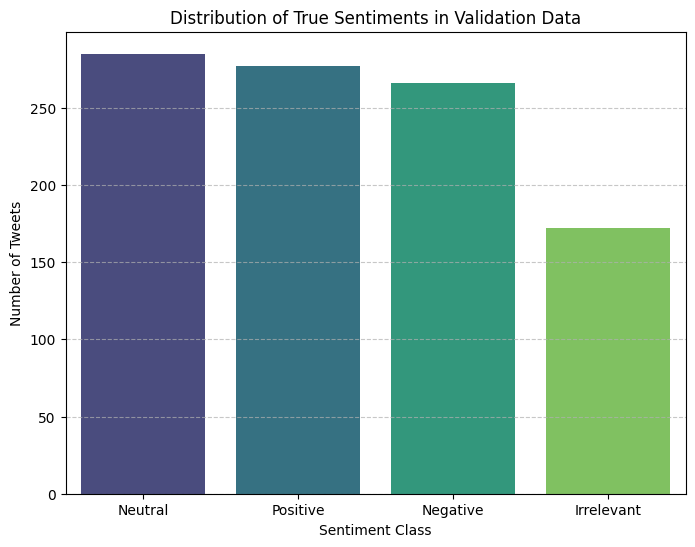

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
data = pd.DataFrame({
    'True Sentiment': y_val,
    'Predicted Sentiment': y_pred
})

sentiment_counts = data['True Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, hue=sentiment_counts.index,palette="viridis",legend=False)
plt.title('Distribution of True Sentiments in Validation Data')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1000x800 with 0 Axes>

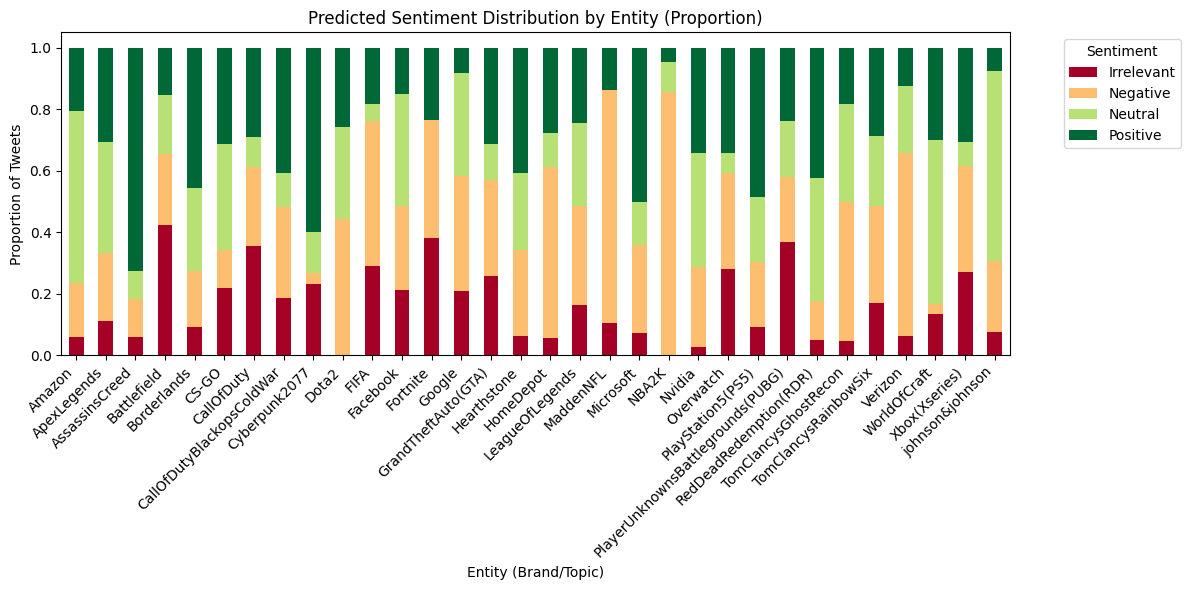

In [28]:
sentiment_classes = sorted(y_val.unique())

val_df['Predicted Sentiment'] = y_pred

entity_sentiment = (
    val_df.groupby(['entity', 'Predicted Sentiment']).size()
    .unstack(fill_value=0)
)


entity_sentiment_prop = entity_sentiment.div(entity_sentiment.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
entity_sentiment_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='RdYlGn'
)
plt.title('Predicted Sentiment Distribution by Entity (Proportion)')
plt.xlabel('Entity (Brand/Topic)')
plt.ylabel('Proportion of Tweets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()